In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,train_test_split

In [146]:
elec=pd.read_csv(r'.\Electricity Consumption.csv')

In [147]:
elec.head(2)

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334


In [148]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [149]:
elec['DATE']=pd.to_datetime(elec['DATE'],format='%d/%m/%Y')

In [150]:
elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.9 KB


In [151]:
elec.isna().sum()

DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

In [152]:
elec

,DATE,Electricty_Consumption_in_TW
0,1973-01-01,35.9728
1,1973-01-02,36.1334
2,1973-01-03,35.0625
3,1973-01-04,33.8416
4,1973-01-05,33.5107
...,...,...
556,2019-01-05,97.5860
557,2019-01-06,110.8580
558,2019-01-07,122.1014
559,2019-01-08,121.7765


In [153]:
elec.set_index('DATE',inplace=True)

In [154]:
elec.index = pd.date_range(start=elec.index[0], periods=len(elec), freq='MS')

In [155]:
elec.head()

,Electricty_Consumption_in_TW
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


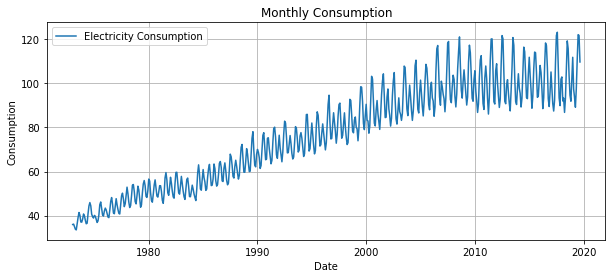

In [156]:
plt.figure(figsize=(10,4))

plt.plot(elec['Electricty_Consumption_in_TW'],label='Electricity Consumption')
plt.title('Monthly Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.legend()
plt.show()

In [157]:
train=elec[:-24] # everything except last 24 months
test=elec[-24:] # predicting for last 24 months

### Decomposition

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose

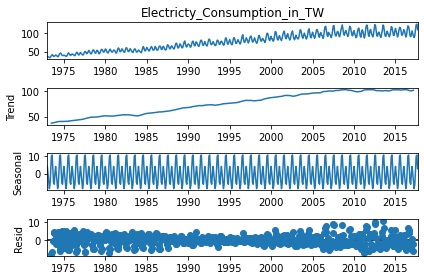

In [159]:
decomp=seasonal_decompose(train['Electricty_Consumption_in_TW'],model='additive',period=12)
decomp.plot()
plt.show()

### ETS

In [160]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [161]:
ets_model=ExponentialSmoothing(train['Electricty_Consumption_in_TW'],trend='additive',seasonal='additive',seasonal_periods=12)
ets_fit=ets_model.fit()
ets_forecast=ets_fit.forecast(24)

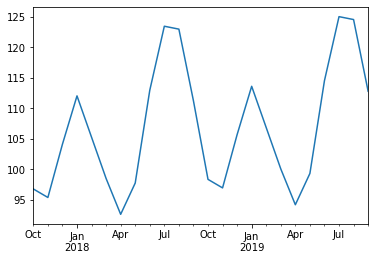

In [162]:
ets_forecast.plot()
plt.show()

### ARIMA

In [163]:
from statsmodels.tsa.arima.model import ARIMA

In [164]:
arima_model=ARIMA(train['Electricty_Consumption_in_TW'],order=(2,1,2))
arima_fit=arima_model.fit()
arima_forecast=arima_fit.forecast(24)

### SARIMA

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [166]:
sarima_model=SARIMAX(train['Electricty_Consumption_in_TW'],order=(1,1,1),seasonal_order=(1,1,1,12))
sarima_fit=sarima_model.fit()
sarima_forecast=sarima_fit.predict(start=test.index[0], end=test.index[-1])

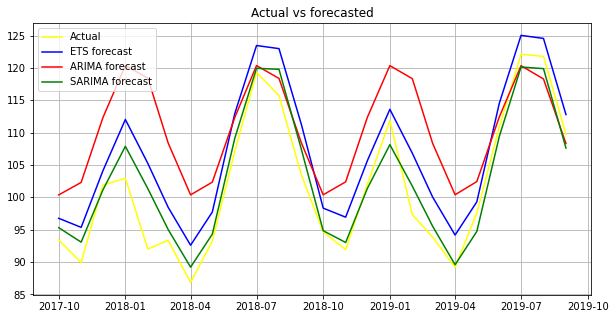

In [167]:
plt.figure(figsize=(10,5))
plt.plot(test.index,test['Electricty_Consumption_in_TW'],label='Actual',color='yellow')
plt.plot(test.index,ets_forecast,label='ETS forecast',color='blue')
plt.plot(test.index,arima_forecast,label='ARIMA forecast',color='red')
plt.plot(test.index,sarima_forecast,label='SARIMA forecast',color='green')
plt.title('Actual vs forecasted')
plt.legend()
plt.grid(True)
plt.show()

#SARIMA seems to be closer to actual

### Model Evaluation

In [168]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [169]:
def eval_model(actual,predict,name):
    mae=mean_absolute_error(actual,predict)
    mape=mean_absolute_percentage_error(actual,predict)
    print(f'{name} Performance:')
    print(f'MAE Score: {mae}')
    print(f'MAPE Score: {mape}')
    return mae,mape

In [170]:
eval_model(test['Electricty_Consumption_in_TW'],ets_forecast,'ETS')
eval_model(test['Electricty_Consumption_in_TW'],arima_forecast,'ARIMA')
eval_model(test['Electricty_Consumption_in_TW'],sarima_forecast,'SARIMA')

# Lower the value of MAE and MAPE better the prediction

# Here it shows SARIMA has lowest values of all, hence will use SARIMA model for prediction

ETS Performance:
MAE Score: 5.1111805971939255
MAPE Score: 0.051528417864928615
ARIMA Performance:
MAE Score: 9.17130938001493
MAPE Score: 0.09511046092049831
SARIMA Performance:
MAE Score: 2.4266569733349512
MAPE Score: 0.02418450669890107


(2.4266569733349512, 0.02418450669890107)

### Plot

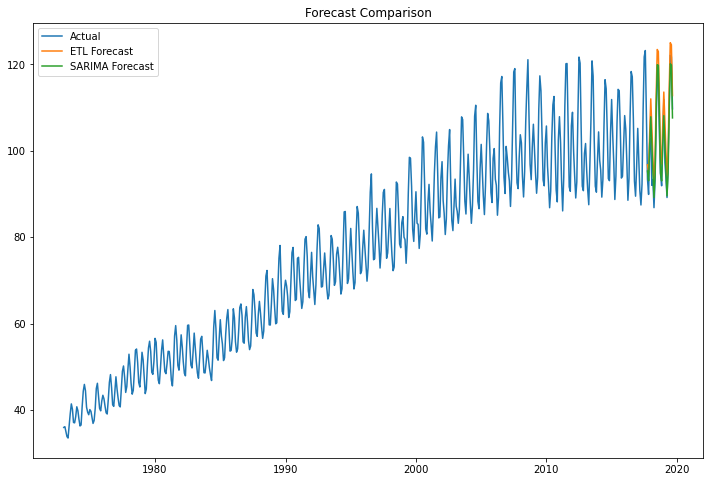

In [171]:
plt.figure(figsize=(12,8))

plt.plot(elec['Electricty_Consumption_in_TW'],label='Actual')
plt.plot(test.index,ets_forecast,label='ETL Forecast')
plt.plot(test.index,sarima_forecast,label='SARIMA Forecast')
plt.title('Forecast Comparison')
plt.legend()
plt.show()

### Using SARIMA

In [246]:
final_model=SARIMAX(elec['Electricty_Consumption_in_TW'],order=(1,1,1),seasonal_order=(1, 1, 1, 12)).fit(disp=False)

In [247]:
final=final_model.forecast(steps=24)

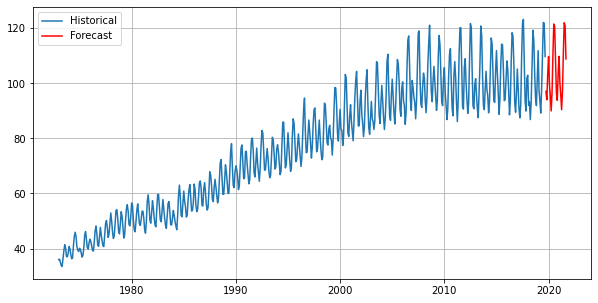

In [248]:
plt.figure(figsize=(10,5))
plt.plot(elec['Electricty_Consumption_in_TW'],label='Historical')
plt.plot(final,label='Forecast',color='red')
plt.legend()
plt.grid(True)
plt.show()

In [249]:
final

2019-10-01     97.040946
2019-11-01     93.994580
2019-12-01    103.302705
2020-01-01    109.735017
2020-02-01     99.555646
2020-03-01     95.672664
2020-04-01     89.961321
2020-05-01     96.434414
2020-06-01    110.387781
2020-07-01    121.539388
2020-08-01    120.587585
2020-09-01    108.421153
2020-10-01     96.348875
2020-11-01     93.783509
2020-12-01    103.358732
2021-01-01    109.805843
2021-02-01     99.963670
2021-03-01     96.132435
2021-04-01     90.411759
2021-05-01     96.814489
2021-06-01    110.819328
2021-07-01    121.976695
2021-08-01    120.999500
2021-09-01    108.831505
Freq: MS, Name: predicted_mean, dtype: float64